**Table of contents**<a id='toc0_'></a>    
- [Preparing the Dataset](#toc1_)    
- [Create Delta table](#toc2_)    
  - [Approach 1 - writeTo](#toc2_1_)    
  - [Approach 2 - SaveAsTable](#toc2_2_)    
- [Read Delta Table](#toc3_)    
- [Create Empty Table](#toc4_)    
  - [Approach 1 Using Create Table](#toc4_1_)    
  - [Approach 2: Using DeltaTableBuilder API](#toc4_2_)    
- [ Upsert to a table](#toc5_)    
- [Filter](#toc6_)    
- [Update a Table](#toc7_)    
- [Delete from a table](#toc8_)    
- [Display table history](#toc9_)    
- [DeltaTable History](#toc10_)    
- [Query an earlier version of the table (time travel)](#toc11_)    
- [Optimize a table](#toc12_)    
- [Clean up snapshots with VACUUM](#toc13_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Preparing the Dataset](#toc0_)

1. From Catalog Explorer, Create a  Catalog
2. Then create a Schema
3. Then create a volume
4. Upload sample dataset(https://www.kaggle.com/datasets/asthamular/people-10-m) under volume

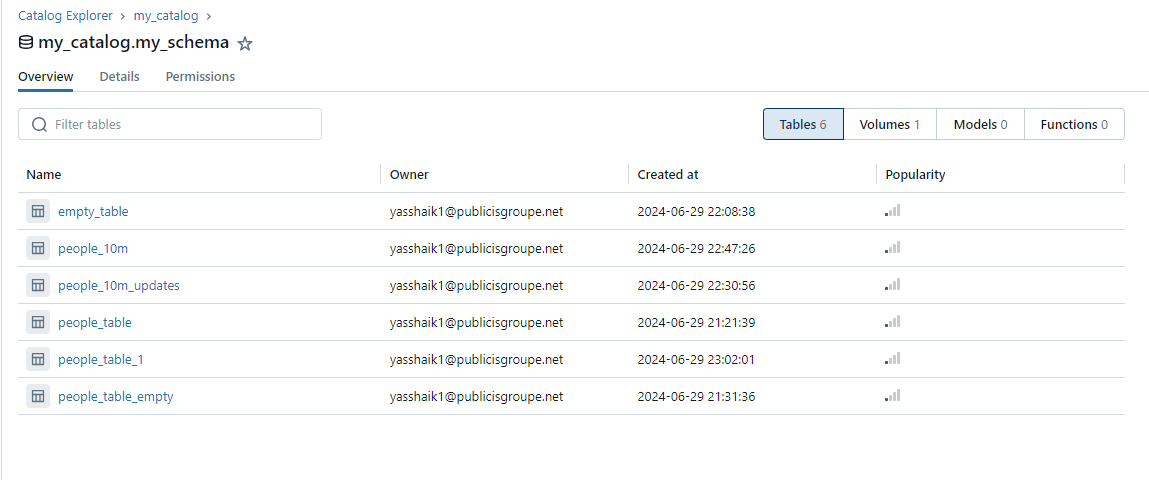

# <a id='toc2_'></a>[Create Delta table](#toc0_)
All tables created on Databricks use Delta Lake by default. Databricks recommends using Unity Catalog managed tables.

## <a id='toc2_1_'></a>[Approach 1 - writeTo](#toc0_)

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType

schema = StructType([
  StructField("id", IntegerType(), True),
  StructField("firstName", StringType(), True),
  StructField("middleName", StringType(), True),
  StructField("lastName", StringType(), True),
  StructField("gender", StringType(), True),
  StructField("birthDate", TimestampType(), True),
  StructField("ssn", StringType(), True),
  StructField("salary", IntegerType(), True)
])

df = spark.read.format("csv").option("header", True).schema(schema).load("/Volumes/my_catalog/my_schema/my_volume/export.csv")

# Create the table if it does not exist. Otherwise, replace the existing table.
df.writeTo("my_catalog.my_schema.people_table").createOrReplace()

# If you know the table does not already exist, you can call this instead:
# df.saveAsTable("main.default.people_10m")

## <a id='toc2_2_'></a>[Approach 2 - SaveAsTable](#toc0_)

In [ ]:
df.write.format("delta").mode("overwrite").saveAsTable("my_catalog.my_schema.people_table_1")


# <a id='toc3_'></a>[Read Delta Table](#toc0_)

In [ ]:
df_1 = spark.read.table("my_catalog.my_schema.people_table_1")
df_1.show()

+---+----------+----------+-------------+------+-------------------+-----------+------+
| id| firstName|middleName|     lastName|gender|          birthDate|        ssn|salary|
+---+----------+----------+-------------+------+-------------------+-----------+------+
|  1|    Pennie|     Carry|   Hirschmann|     F|1955-07-02 04:00:00|981-43-9345| 56172|
|  2|        An|     Amira|       Cowper|     F|1992-02-08 05:00:00|978-97-8086| 40203|
|  3|     Quyen|    Marlen|         Dome|     F|1970-10-11 04:00:00|957-57-8246| 53417|
|  4|   Coralie|  Antonina|      Marshal|     F|1990-04-11 04:00:00|963-39-4885| 94727|
|  5|    Terrie|      Wava|        Bonar|     F|1980-01-16 05:00:00|964-49-8051| 79908|
|  6|  Chassidy|Concepcion|Bourthouloume|     F|1990-11-24 05:00:00|954-59-9172| 64652|
|  7|      Geri|    Tambra|        Mosby|     F|1970-12-19 05:00:00|968-16-4020| 38195|
|  8|    Patria|     Nancy|      Arstall|     F|1985-01-02 05:00:00|984-76-3770|102053|
|  9|    Terese|  Alfredia|     

In [ ]:
deltaTable = DeltaTable.forName(spark, 'my_catalog.my_schema.people_table_1')
deltaTable.toDF().show()

+---+----------+----------+-------------+------+-------------------+-----------+------+
| id| firstName|middleName|     lastName|gender|          birthDate|        ssn|salary|
+---+----------+----------+-------------+------+-------------------+-----------+------+
|  1|    Pennie|     Carry|   Hirschmann|     F|1955-07-02 04:00:00|981-43-9345| 56172|
|  2|        An|     Amira|       Cowper|     F|1992-02-08 05:00:00|978-97-8086| 40203|
|  3|     Quyen|    Marlen|         Dome|     F|1970-10-11 04:00:00|957-57-8246| 53417|
|  4|   Coralie|  Antonina|      Marshal|     F|1990-04-11 04:00:00|963-39-4885| 94727|
|  5|    Terrie|      Wava|        Bonar|     F|1980-01-16 05:00:00|964-49-8051| 79908|
|  6|  Chassidy|Concepcion|Bourthouloume|     F|1990-11-24 05:00:00|954-59-9172| 64652|
|  7|      Geri|    Tambra|        Mosby|     F|1970-12-19 05:00:00|968-16-4020| 38195|
|  8|    Patria|     Nancy|      Arstall|     F|1985-01-02 05:00:00|984-76-3770|102053|
|  9|    Terese|  Alfredia|     

# <a id='toc4_'></a>[Create Empty Table](#toc0_)

All tables created on Databricks use Delta Lake by default. Databricks recommends using Unity Catalog managed tables.


## <a id='toc4_1_'></a>[Approach 1 Using Create Table](#toc0_)

In Databricks Runtime 13.3 LTS and above, you can use CREATE TABLE LIKE to create a new empty Delta table that duplicates the schema and table properties for a source Delta table. This can be especially useful when promoting tables from a development environment into production

In [ ]:
%sql
CREATE TABLE my_catalog.my_schema.people_table_empty LIKE my_catalog.my_schema.people_table


In [ ]:
# Execute SQL query and store the result in a DataFrame
df = spark.sql("SELECT * FROM my_catalog.my_schema.people_table_empty")

# Display the DataFrame
display(df)

id,firstName,middleName,lastName,gender,birthDate,ssn,salary


## <a id='toc4_2_'></a>[Approach 2: Using DeltaTableBuilder API](#toc0_)

To create an empty table, you can also use the DeltaTableBuilder API in Delta Lake for Python and Scala. Compared to equivalent DataFrameWriter APIs, these APIs make it easier to specify additional information like column comments, table properties, and generated columns.

In [ ]:
from delta.tables import DeltaTable

(DeltaTable.createIfNotExists(spark)
  .tableName("my_catalog.my_schema.empty_table")
  .addColumn("id", "INT")
  .addColumn("firstName", "STRING")
  .addColumn("middleName", "STRING")
  .addColumn("lastName", "STRING", comment = "surname")
  .addColumn("gender", "STRING")
  .addColumn("birthDate", "TIMESTAMP")
  .addColumn("ssn", "STRING")
  .addColumn("salary", "INT")
  .execute()
)

In [ ]:
# Execute SQL query and store the result in a DataFrame
df = spark.sql("SELECT * FROM my_catalog.my_schema.empty_table")

# Display the DataFrame
display(df)

id,firstName,middleName,lastName,gender,birthDate,ssn,salary


# <a id='toc5_'></a>[ Upsert to a table](#toc0_)

To merge a set of updates and insertions into an existing Delta table.  you use the 
- DeltaTable.merge - PYTHON
- MERGE INTO - SQL

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from datetime import date
from delta.tables import DeltaTable

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from datetime import date
from delta.tables import DeltaTable

# Initialize Spark session
spark = SparkSession.builder.appName("DeltaTableExample").getOrCreate()

# Schema definition
schema = StructType([
  StructField("id", IntegerType(), True),
  StructField("firstName", StringType(), True),
  StructField("middleName", StringType(), True),
  StructField("lastName", StringType(), True),
  StructField("gender", StringType(), True),
  StructField("birthDate", DateType(), True),
  StructField("ssn", StringType(), True),
  StructField("salary", IntegerType(), True)
])

# Full Data
data = [
  (1, 'John', 'A', 'Smith', 'M', date.fromisoformat('1980-01-01'), '123-45-6789', 50000),
  (2, 'Jane', 'B', 'Doe', 'F', date.fromisoformat('1985-02-02'), '987-65-4321', 60000)
]

people_10m = spark.createDataFrame(data, schema)
people_10m.write.format("delta").mode("overwrite").saveAsTable("my_catalog.my_schema.people_10m")

# Verify Table
spark.sql("SELECT * FROM my_catalog.my_schema.people_10m").show()


+---+---------+----------+--------+------+----------+-----------+------+
| id|firstName|middleName|lastName|gender| birthDate|        ssn|salary|
+---+---------+----------+--------+------+----------+-----------+------+
|  1|     John|         A|   Smith|     M|1980-01-01|123-45-6789| 50000|
|  2|     Jane|         B|     Doe|     F|1985-02-02|987-65-4321| 60000|
+---+---------+----------+--------+------+----------+-----------+------+



In [ ]:
# Incremental Data
incremental_data = [
  (2, 'Jane', 'B', 'Doe', 'F', date.fromisoformat('1985-02-02'), '987-65-4321', 65000),  # Updated salary
  (3, 'Alice', 'C', 'Johnson', 'F', date.fromisoformat('1990-03-03'), '555-55-5555', 70000)  # New entry
]

people_10m_updates = spark.createDataFrame(incremental_data, schema)
people_10m_updates.write.format("delta").mode("overwrite").saveAsTable("my_catalog.my_schema.people_10m_updates")

# Verify Update Table
spark.sql("SELECT * FROM my_catalog.my_schema.people_10m_updates").show()


+---+---------+----------+--------+------+----------+-----------+------+
| id|firstName|middleName|lastName|gender| birthDate|        ssn|salary|
+---+---------+----------+--------+------+----------+-----------+------+
|  3|    Alice|         C| Johnson|     F|1990-03-03|555-55-5555| 70000|
|  2|     Jane|         B|     Doe|     F|1985-02-02|987-65-4321| 65000|
+---+---------+----------+--------+------+----------+-----------+------+



In [ ]:
# Load the Delta tables
deltaTable = DeltaTable.forName(spark, 'my_catalog.my_schema.people_10m')
updatesTable = DeltaTable.forName(spark, 'my_catalog.my_schema.people_10m_updates')

# Perform merge
(deltaTable.alias("people_10m")
  .merge(
    updatesTable.toDF().alias("people_10m_updates"),
    "people_10m.id = people_10m_updates.id")
  .whenMatchedUpdateAll()
  .whenNotMatchedInsertAll()
    # .whenNotMatchedBySourceDelete()
  .execute()
)

# Verify the updated table
spark.sql("SELECT * FROM my_catalog.my_schema.people_10m").show()


+---+---------+----------+--------+------+----------+-----------+------+
| id|firstName|middleName|lastName|gender| birthDate|        ssn|salary|
+---+---------+----------+--------+------+----------+-----------+------+
|  3|    Alice|         C| Johnson|     F|1990-03-03|555-55-5555| 70000|
|  2|     Jane|         B|     Doe|     F|1985-02-02|987-65-4321| 65000|
|  1|     John|         A|   Smith|     M|1980-01-01|123-45-6789| 50000|
+---+---------+----------+--------+------+----------+-----------+------+



# <a id='toc6_'></a>[Filter](#toc0_)

In [ ]:
df = spark.read.table("my_catalog.my_schema.people_10m")
df_filtered = df.filter(df["id"] >= 2)
display(df_filtered)

id,firstName,middleName,lastName,gender,birthDate,ssn,salary
3,Alice,C,Johnson,F,1990-03-03,555-55-5555,70000
2,Jane,B,Doe,F,1985-02-02,987-65-4321,65000


# <a id='toc7_'></a>[Update a Table](#toc0_)

In [ ]:
from pyspark.sql.functions import *

deltaTable  = DeltaTable.forName(spark,"my_catalog.my_schema.people_10m")

# Declare the predicate by using a SQL-formatted string.
deltaTable.update(
  condition = "gender = 'F'",
  set = { "gender": "'Female'" }
)

# Declare the predicate by using Spark SQL functions.
deltaTable.update(
  condition = col('gender') == 'M',
  set = { 'gender': lit('Male') }
)

deltaTable  = DeltaTable.forName(spark, "my_catalog.my_schema.people_10m")
deltaTable.toDF().show()


+---+---------+----------+--------+------+----------+-----------+------+
| id|firstName|middleName|lastName|gender| birthDate|        ssn|salary|
+---+---------+----------+--------+------+----------+-----------+------+
|  3|    Alice|         C| Johnson|Female|1990-03-03|555-55-5555| 70000|
|  2|     Jane|         B|     Doe|Female|1985-02-02|987-65-4321| 65000|
|  1|     John|         A|   Smith|  Male|1980-01-01|123-45-6789| 50000|
+---+---------+----------+--------+------+----------+-----------+------+



# <a id='toc8_'></a>[Delete from a table](#toc0_)

In [ ]:
deltaTable  = DeltaTable.forName(spark, "my_catalog.my_schema.people_10m")
deltaTable.delete(col('salary') < '65000')

deltaTable  = DeltaTable.forName(spark, "my_catalog.my_schema.people_10m")
deltaTable.toDF().show()

+---+---------+----------+--------+------+----------+-----------+------+
| id|firstName|middleName|lastName|gender| birthDate|        ssn|salary|
+---+---------+----------+--------+------+----------+-----------+------+
|  3|    Alice|         C| Johnson|Female|1990-03-03|555-55-5555| 70000|
|  2|     Jane|         B|     Doe|Female|1985-02-02|987-65-4321| 65000|
+---+---------+----------+--------+------+----------+-----------+------+



# <a id='toc9_'></a>[Display table history](#toc0_)

In [ ]:
from delta.tables import *

deltaTable  = DeltaTable.forName(spark, "my_catalog.my_schema.people_10m")
display(deltaTable.history())

version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata,engineInfo
7,2024-06-29T18:06:44Z,4205264871713714,yasshaik1@publicisgroupe.net,DELETE,"Map(predicate -> [""(salary#18983 < 65000)""])",null,List(3173428219033775),0629-085601-52xi3frn,6,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2189, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 752, numDeletionVectorsUpdated -> 0, numDeletedRows -> 1, scanTimeMs -> 639, numAddedFiles -> 0, numAddedBytes -> 0, rewriteTimeMs -> 111)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
6,2024-06-29T18:01:45Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#17531 = M)""])",null,List(3173428219033775),0629-085601-52xi3frn,5,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 328, numDeletionVectorsUpdated -> 0, scanTimeMs -> 328, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
5,2024-06-29T18:01:43Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#17531 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,4,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 622, numDeletionVectorsUpdated -> 0, scanTimeMs -> 621, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
4,2024-06-29T18:01:23Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#15751 = M)""])",null,List(3173428219033775),0629-085601-52xi3frn,3,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2168, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 1722, numDeletionVectorsUpdated -> 0, scanTimeMs -> 987, numAddedFiles -> 1, numUpdatedRows -> 1, numAddedBytes -> 2189, rewriteTimeMs -> 734)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
3,2024-06-29T18:01:19Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#15751 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,2,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 559, numDeletionVectorsUpdated -> 0, scanTimeMs -> 559, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
2,2024-06-29T18:00:53Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#14688 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,1,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2192, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 2273, numDeletionVectorsUpdated -> 0, scanTimeMs -> 910, numAddedFiles -> 1, numUpdatedRows -> 2, numAddedBytes -> 2228, rewriteTimeMs -> 1361)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
1,2024-06-29T17:17:59Z,4205264871713714,yasshaik1@publicisgroupe.net,MERGE,"Map(predicate -> [""(id#11382 = id#11406)""], matchedPredicates -> [{""actionType"":""update""}], statsOnLoad -> false, notMatchedBySourcePredicates -> [], notMatchedPredicates -> [{""actionType"":""insert""}])",null,List(3173428219033775),0629-085601-52xi3frn,0,WriteSerializable,false,"Map(numTargetRowsCopied -> 0, numTargetRowsDeleted -> 0, numTargetFilesAdded -> 1, numTarge

# <a id='toc10_'></a>[DeltaTable History](#toc0_)

In [ ]:
from delta.tables import *

deltaTable  = DeltaTable.forName(spark, "my_catalog.my_schema.people_10m")
deltaHistory = deltaTable.history()

display(deltaHistory.where("version == 3"))
# Or:
display(deltaHistory.where("timestamp == '2024-06-29T18:06:44.000+00:00'"))


version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata,engineInfo
3,2024-06-29T18:01:19Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#15751 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,2,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 559, numDeletionVectorsUpdated -> 0, scanTimeMs -> 559, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12


version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata,engineInfo
7,2024-06-29T18:06:44Z,4205264871713714,yasshaik1@publicisgroupe.net,DELETE,"Map(predicate -> [""(salary#18983 < 65000)""])",null,List(3173428219033775),0629-085601-52xi3frn,6,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2189, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 752, numDeletionVectorsUpdated -> 0, numDeletedRows -> 1, scanTimeMs -> 639, numAddedFiles -> 0, numAddedBytes -> 0, rewriteTimeMs -> 111)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12


# <a id='toc11_'></a>[Query an earlier version of the table (time travel)](#toc0_)

In [ ]:
df_1 = spark.read.option('versionAsOf', 0).table("my_catalog.my_schema.people_10m")
df_1.show()


df_2 = spark.read.option('timestampAsOf', '2024-06-29T18:06:44.000+00:00').table("my_catalog.my_schema.people_10m")
df_2.show()

+---+---------+----------+--------+------+----------+-----------+------+
| id|firstName|middleName|lastName|gender| birthDate|        ssn|salary|
+---+---------+----------+--------+------+----------+-----------+------+
|  1|     John|         A|   Smith|     M|1980-01-01|123-45-6789| 50000|
|  2|     Jane|         B|     Doe|     F|1985-02-02|987-65-4321| 60000|
+---+---------+----------+--------+------+----------+-----------+------+

+---+---------+----------+--------+------+----------+-----------+------+
| id|firstName|middleName|lastName|gender| birthDate|        ssn|salary|
+---+---------+----------+--------+------+----------+-----------+------+
|  3|    Alice|         C| Johnson|Female|1990-03-03|555-55-5555| 70000|
|  2|     Jane|         B|     Doe|Female|1985-02-02|987-65-4321| 65000|
+---+---------+----------+--------+------+----------+-----------+------+



# <a id='toc12_'></a>[Optimize a table](#toc0_)

In [ ]:
from delta.tables import *

deltaTable = DeltaTable.forName(spark, "my_catalog.my_schema.people_10m")
deltaTable.optimize()

In [ ]:
from delta.tables import *

deltaTable = DeltaTable.forName(spark, "my_catalog.my_schema.people_10m")
deltaTable.optimize().executeZOrderBy("gender")


DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,clusteringStats:struct<inputZCubeFiles:struct<numFiles:bigint,size:bigint>,inputOtherFiles:struct<numFiles:bigint,size:bigint>,inputNumZCubes:bigint,mergedFiles:struct<numFiles:bigint,size:bigint>,numOutputZCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterPar

# <a id='toc13_'></a>[Clean up snapshots with VACUUM](#toc0_)

In [ ]:
from delta.tables import *

deltaTable  = DeltaTable.forName(spark, "my_catalog.my_schema.people_10m")
display(deltaTable.history())

deltaTable.vacuum()

deltaTable  = DeltaTable.forName(spark, "my_catalog.my_schema.people_10m")
display(deltaTable.history())


version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata,engineInfo
7,2024-06-29T18:06:44Z,4205264871713714,yasshaik1@publicisgroupe.net,DELETE,"Map(predicate -> [""(salary#18983 < 65000)""])",null,List(3173428219033775),0629-085601-52xi3frn,6,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2189, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 752, numDeletionVectorsUpdated -> 0, numDeletedRows -> 1, scanTimeMs -> 639, numAddedFiles -> 0, numAddedBytes -> 0, rewriteTimeMs -> 111)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
6,2024-06-29T18:01:45Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#17531 = M)""])",null,List(3173428219033775),0629-085601-52xi3frn,5,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 328, numDeletionVectorsUpdated -> 0, scanTimeMs -> 328, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
5,2024-06-29T18:01:43Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#17531 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,4,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 622, numDeletionVectorsUpdated -> 0, scanTimeMs -> 621, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
4,2024-06-29T18:01:23Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#15751 = M)""])",null,List(3173428219033775),0629-085601-52xi3frn,3,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2168, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 1722, numDeletionVectorsUpdated -> 0, scanTimeMs -> 987, numAddedFiles -> 1, numUpdatedRows -> 1, numAddedBytes -> 2189, rewriteTimeMs -> 734)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
3,2024-06-29T18:01:19Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#15751 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,2,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 559, numDeletionVectorsUpdated -> 0, scanTimeMs -> 559, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
2,2024-06-29T18:00:53Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#14688 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,1,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2192, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 2273, numDeletionVectorsUpdated -> 0, scanTimeMs -> 910, numAddedFiles -> 1, numUpdatedRows -> 2, numAddedBytes -> 2228, rewriteTimeMs -> 1361)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
1,2024-06-29T17:17:59Z,4205264871713714,yasshaik1@publicisgroupe.net,MERGE,"Map(predicate -> [""(id#11382 = id#11406)""], matchedPredicates -> [{""actionType"":""update""}], statsOnLoad -> false, notMatchedBySourcePredicates -> [], notMatchedPredicates -> [{""actionType"":""insert""}])",null,List(3173428219033775),0629-085601-52xi3frn,0,WriteSerializable,false,"Map(numTargetRowsCopied -> 0, numTargetRowsDeleted -> 0, numTargetFilesAdded -> 1, numTarge

version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata,engineInfo
9,2024-06-29T18:22:26Z,4205264871713714,yasshaik1@publicisgroupe.net,VACUUM END,Map(status -> COMPLETED),null,List(3173428219033775),0629-085601-52xi3frn,8,SnapshotIsolation,true,"Map(numDeletedFiles -> 0, numVacuumedDirectories -> 1)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
8,2024-06-29T18:22:22Z,4205264871713714,yasshaik1@publicisgroupe.net,VACUUM START,"Map(retentionCheckEnabled -> true, defaultRetentionMillis -> 604800000)",null,List(3173428219033775),0629-085601-52xi3frn,7,SnapshotIsolation,true,"Map(numFilesToDelete -> 0, sizeOfDataToDelete -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
7,2024-06-29T18:06:44Z,4205264871713714,yasshaik1@publicisgroupe.net,DELETE,"Map(predicate -> [""(salary#18983 < 65000)""])",null,List(3173428219033775),0629-085601-52xi3frn,6,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2189, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 752, numDeletionVectorsUpdated -> 0, numDeletedRows -> 1, scanTimeMs -> 639, numAddedFiles -> 0, numAddedBytes -> 0, rewriteTimeMs -> 111)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
6,2024-06-29T18:01:45Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#17531 = M)""])",null,List(3173428219033775),0629-085601-52xi3frn,5,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 328, numDeletionVectorsUpdated -> 0, scanTimeMs -> 328, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
5,2024-06-29T18:01:43Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#17531 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,4,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 622, numDeletionVectorsUpdated -> 0, scanTimeMs -> 621, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
4,2024-06-29T18:01:23Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#15751 = M)""])",null,List(3173428219033775),0629-085601-52xi3frn,3,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2168, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 1722, numDeletionVectorsUpdated -> 0, scanTimeMs -> 987, numAddedFiles -> 1, numUpdatedRows -> 1, numAddedBytes -> 2189, rewriteTimeMs -> 734)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
3,2024-06-29T18:01:19Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#15751 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,2,WriteSerializable,false,"Map(numRemovedFiles -> 0, numRemovedBytes -> 0, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 559, numDeletionVectorsUpdated -> 0, scanTimeMs -> 559, numAddedFiles -> 0, numUpdatedRows -> 0, numAddedBytes -> 0, rewriteTimeMs -> 0)",null,Databricks-Runtime/15.3.x-cpu-ml-scala2.12
2,2024-06-29T18:00:53Z,4205264871713714,yasshaik1@publicisgroupe.net,UPDATE,"Map(predicate -> [""(gender#14688 = F)""])",null,List(3173428219033775),0629-085601-52xi3frn,1,WriteSerializable,false,"Map(numRemovedFiles -> 1, numRemovedBytes -> 2192, numCopiedRows -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 2273, numDeletionVectorsUpdated 